# Optimization II Project 3

In [9]:
import numpy as np
import gym
import tensorflow as tf
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Input, MaxPool2D, MaxPool1D
from tensorflow import keras
from tqdm import tqdm

import matplotlib.pyplot as plt

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # stop displaying warnings that mean nothing!!!

In [10]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit
# # %tensorboard --logdir=data/ --host localhost --port 8888

# Google Colab

In [11]:
PATH = 'drive/MyDrive/MS/Opti/Project3/'

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m atari_py.import_roms /content/drive/MyDrive/MS/Opti/Roms/

copying atlantis.bin from /content/drive/MyDrive/MS/Opti/Roms/HC ROMS/BY ALPHABET/A-G/Atlantis.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/atlantis.bin
copying chopper_command.bin from /content/drive/MyDrive/MS/Opti/Roms/HC ROMS/BY ALPHABET/A-G/Chopper Command.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/chopper_command.bin
copying breakout.bin from /content/drive/MyDrive/MS/Opti/Roms/HC ROMS/BY ALPHABET/A-G/Breakout - Breakaway IV.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/breakout.bin
copying boxing.bin from /content/drive/MyDrive/MS/Opti/Roms/HC ROMS/BY ALPHABET/A-G/Boxing.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/boxing.bin
copying freeway.bin from /content/drive/MyDrive/MS/Opti/Roms/HC ROMS/BY ALPHABET/A-G/Freeway.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/freeway.bin
copying bank_heist.bin from /content/drive/MyDrive/MS/Opti/Roms/HC ROMS/BY ALPHABET/A-G/Bank Heist.bin 

## I: Pong (Till we win)

In [ ]:
def prepro(I):
    # preprocess each frame for learning
    # save some memory and computation
    # pre-process the image from a 210x160x3 uint8 frame into an (80x80) float array )
    # print(I.shape)
    I = I[::2,:,0].copy() # downsample by factor of 2
    # print(I.shape)
    # print(I.shape)
    dim = I.shape
    I = I.reshape(dim[0], dim[1])   # convert to a 2D array
    I = I[10:,::] # remove the top 7 rows of pixels : Score

    # I[I == 144] = 0 # erase background (background type 1)
    # I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    I = np.any( np.array(np.array_split(I, I.shape[1]//2, axis=1)) == 1, axis = 2).T
 
    return np.array(I)


def segment_env(I):
    '''
        segment the environment into 4 parts
        returns a list of 4 images
        Mothership, spawns, spaceship, lives, gun_heat
    '''
    I = I.copy()
    I = prepro(I)
    row_count, col_count = I.shape
    # Mothership
    I_mothership = I[:10, :]
    I_mothership = np.any(I_mothership == 1, axis=0).reshape(1, col_count)
    
    # Spawns
    I_spawns = I[10:row_count - 16, :]
    I_spawns = np.array([np.any(x == 1, axis=0) for x in np.array_split(I_spawns, I_spawns.shape[0]//2, axis=0)])

    # Spaceship
    I_spaceship = I[row_count-16:row_count-12, :]
    I_spaceship = np.any(I_spaceship == 1, axis=0).reshape(1, col_count)
    
    num_bombs = -1 # at least 1 object in this line...my bot
    for i in range(1,I_spaceship.shape[1]):
        if I_spaceship[0][i] == 1 and I_spaceship[0][i-1] == 1:
            num_bombs += 1
    
    # Lets not bother about this now
    # Lives
    I_lives = I[row_count-10:row_count-5, :col_count//2]
    I_lives = np.any(I_lives == 1, axis=0).reshape(1, col_count//2)
    split = np.array(np.array_split(I_lives[:, 4:], 4, axis = 1))
    num_lives = np.any(split == 1, axis = 2).sum() + 1
    # print('Num Lives',num_lives)
    
    # gun_heat
    I_gun_heat = I[row_count-10:row_count-5, col_count//2:]
    I_gun_heat = np.any(I_gun_heat == 1, axis=0).reshape(1, col_count//2)
    
    heat_gun_padding = 8
    percent_heat = I_gun_heat[:, heat_gun_padding:].sum() / I_gun_heat[:, heat_gun_padding:].shape[1]
    # print('Percent Heat', percent_heat)

    I_health = np.concatenate((I_lives, I_gun_heat), axis=1)

    segment_list = [I_mothership, I_spawns, I_spaceship]#, I_health]
    # return segment_list
    return np.concatenate(segment_list, axis=0), num_lives, percent_heat

In [ ]:
def plot_environment(I):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex= False, sharey= False)
    ax[0].imshow(I)
    # segment_list = segment_env(I)
    # prep_im = np.concatenate(segment_list, axis=0)
    prep_im, _, _ = segment_env(I)
    ax[1].imshow(prep_im, cmap='gray')
    plt.show()

In [ ]:
frames_to_net = 1
frames_this_game = 0

env = gym.make("Assault-v0")

pix = env.reset()
for i in range(15):
    pix, reward, done, info = env.step(env.action_space.sample()) # take a random action
plot_environment(pix)
board_dimensions = segment_env(pix)[0].shape

# pix = prepro(pix)
# dimensions = pix.shape


env.reset()
env.close()

print(board_dimensions)

In [ ]:
env.unwrapped.get_action_meanings()

### Policy Gradient with linear annealing, memory buffer, and same action for 4 consecutive frames

In [ ]:
def discount_rewards(r):
    # take 1D float array of rewards and compute discounted reward
    # gym returns a reward with every single frame.  most of those rewards are 0
    # sometimes they're 1 or -1 if we win or lose a point in that specific frame
    # we want non-0 rewards for every frame. 
    # so take each frame, figure out if we eventually won the corresponding point or not
    # if so make the reward positive, if not negative
    # but more recent actions (relative to the frame where the point is awarded) are more 
    # impactful to the score that frames a long time ago, so discount rewards...
    
    delt = 0.99 # discount factor
    nr = len(r)
    # we want to change all those zeros into discounted values of the next reward (this is the value function!)
    discounted_r = [0.0]*nr
    
    for t in range(nr):
        # start at the end
        if r[nr-t-1] > 0: # if you won a point in this frame we want a good reward
            discounted_r[nr-t-1] = 1
        elif r[nr-t-1] < 0: # if we lost the point we want a bad reward
            discounted_r[nr-t-1] = -1
        elif t==0: # this is just for error catching...at t==0 r[nr-t-1] should have already been + or -...
            discounted_r[nr-t-1] = 0
        elif discounted_r[nr-t-1] == 0: # otherwise you want to look at the next reward value and discount it
            discounted_r[nr-t-1] = delt*discounted_r[nr-t]
    return discounted_r

In [ ]:
frames_to_net = 4              # how many previous frames will we feed the NN
possible_actions = [x for x in range(env.unwrapped.action_space.n)] # the possible actions we can take

## Play the game

In [ ]:
def play1game(model, action_space, ep = 0, render=False, slow= 0.01, record=False):
    if record:
        env0 = Monitor(gym.make("Assault-v0"), './videos/assault-v0', force=True, video_callable=lambda episode_id: True)
    else:
        env0 = gym.make("Assault-v0")

    pix = env0.reset()
    pix, num_lives, percent_heat = segment_env(pix)
    
    num_bombs = -1 # at least 1 object in this line...my bot
    for i in range(1,pix.shape[1],3):
        if pix[-1,i] == 1 and pix[-1,i-1] == 1:
            num_bombs += 1
    
    health = np.array([num_lives, percent_heat]).reshape((1,2))
    dimensions = pix.shape

    action_space = env0.unwrapped.action_space.n -2 # the -2 is because we don't want to fire left or right
    possible_actions = np.array([i for i in range(action_space)])
    
    frames_this_game = 0
    feed = np.zeros((1, dimensions[0], dimensions[1],frames_to_net))
    feed[0,:,:,0] = pix.copy()
    
    health_feed = np.zeros((1,1,2, frames_to_net))
    health_feed[0,:,:,0] = health.copy()
    
    
    frame_array = []
    health_array = []
    action_array = []
    reward_array = []
    
    score = 0
    action = 0
    done = False
    try:
        while not done:
            if render: # do you actually want to visualize the playing?
                env0.render()
                time.sleep(slow)
            elif record:
                env0.render(mode='rgb_array')
            
            # skipping every 4 frames
            if frames_this_game%4 == 0:
                vf = model([feed, health_feed ],training=False).numpy()[0]
                    # epsilon-greedy
                if np.random.random() < ep:
                    action = np.random.choice(action_space)
                else:
                    action = np.random.choice(possible_actions,p=vf)
            
            if num_bombs > 0: # if we have a bomb, we want to fire left/right
                action = np.random.choice([0,1], p=[0.5, 0.5]) + action_space - 1

            # action0 = possible_actions[action]
            pix_new, reward, done, info = env0.step(action)
            pix, num_lives, percent_heat = segment_env(pix_new)
            health = np.array([num_lives, percent_heat]).reshape((1,2))

            frame_array.append(pix)
            action_array.append(action)
            reward_array.append(reward)
            health_array.append(health)
            frames_this_game += 1

            for f in range(1,frames_to_net):
                feed[0,:,:,frames_to_net-f] = feed[0,:,:,frames_to_net-f-1].copy()
            feed[0,:,:,0] = pix.copy()
            score += reward

            if frames_this_game > 5000:#5000000:
                print("Game is taking too long, breaking")
                done = True

    except Exception as e:
        print(e)
    except KeyboardInterrupt:
        print('KeyboardInterrupt')
    finally:
        env0.reset()
        env0.close()
    return frame_array, health_array, action_array, reward_array, score

# Visualise the game after training

In [ ]:
model_name = 'V2_assault_2_0'
# model_name = 'V2_assault_2_full_action_space_'

mod2 = tf.keras.models.load_model(f'{model_name}.tf')
mod2.call = tf.function(mod2.call,experimental_relax_shapes=True)

mod2.summary()

Model: "dual_input_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board_input (InputLayer)       [(None, 36, 80, 4)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 38, 32)   3232        ['board_input[0][0]']            
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 8, 19, 32)   0           ['conv1[0][0]']                  
                                                                                                  
 conv2 (Conv2D)                 (None, 2, 4, 16)     8208        ['max_pooling2d_3[0][0]']        
                                                                                   

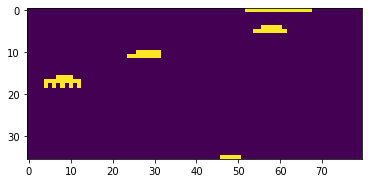

In [ ]:
frame_array, health_array, action_array, reward_array, score = play1game(mod2, 7, 0, render=False, slow= 0.015, record=True)

plt.imshow(frame_array[-1])

In [ ]:
ngames = 1000
scores = np.zeros(ngames)
for game in tqdm(range(ngames)):
    frames, health, actions, rewards, score = play1game(mod2, 7, ep = 0)
    scores[game] = score

np.mean(scores)

 10%|█         | 101/1000 [06:30<1:04:39,  4.32s/it]